In [8]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np
import scipy.optimize
from schwimmbad import MPIPool

def biasFunc(x, m, c):
    '''Systematic bias of shear estimation
    Parameters:
    ----
    x:  input shear
    m:  multiplicative bias
    c:  additive bias

    Returns:
    ----
    y:  estimated shear
    '''
    y   =   (1+m) * x + c
    return y

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        #data['s2n'] = res['s2n']
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data

In [9]:
def make_data(rng, FbyB, shear, version=0, SbyN=20):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    FbyB: float
        source by background ratio
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear,
        g2=0,
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    radius = 10
    
    ngrid = im.array.shape[0]
    flux_tmp = np.sum((im.array)[ngrid//2-radius:ngrid//2+radius+1, ngrid//2-radius:ngrid//2+radius+1])
    F = SbyN**2.*(1+FbyB)/FbyB
    B = F/FbyB
    B_val = B/(2.*radius+1)**2.
    F_val= F/(2.*radius+1)**2.
        
    im = (im/flux_tmp)*F
    
    
    if version==0:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val + im.array)
            
    if version==1:
        noise_image = rng.normal(scale=1, size=im.array.shape)
        noise_image *= np.sqrt(B_val+F_val)

    variance_array = np.ones_like(im.array)*(B_val+F_val)
    im += noise_image
    wt = 1.0/variance_array
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
        
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [10]:
"""
analyze(num_gals, FbyB, shear_true, seedArr, version=0, first=False, SbyN=20):
    info
    if ~version:
        print('Analyzing for F/B= %.2f' %FbyB)
    else:
        print('Analyzing for F/B= 0')
    data = []
    x = []
    y = []
    s2nArr=[]
    shear_error = []
    
    for i in range(len(shear_true)):
        seedNum = seedArr[i]
        rng = np.random.RandomState(seedNum)
        shearIn = shear_true[i]
        print('Analyzing for shear= %.2f' %shearIn)
        
        dlist = []
        
        for j in range(num_gals):
            imgdata = make_data(rng=rng, FbyB=FbyB, shear=shearIn, version=version, SbyN=SbyN)
            obs = imgdata

            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                del st
            del obs, resdict, obsdict

        data = np.hstack(dlist)
        del dlist
        
        w = select(data=data, shear_type='noshear')
        w_1p = select(data=data, shear_type='1p')
        w_1m = select(data=data, shear_type='1m')
        g_1p = data['g'][w_1p, 0].mean()
        g_1m = data['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        s2n = data['s2n'].mean()

        g = data['g'][w].mean(axis=0)
        shear = g / R11

        g_error = data['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)

        x.append(FbyB)
        y.append(shear[0])
        s2nArr.append(s2n)
        del data
        

            
    return (x, y, shear_error, s2nArr)
"""

In [21]:
def analyze(info):
    info
    if ~version:
        print('Analyzing for F/B= %.2f' %info[1])
    else:
        print('Analyzing for F/B= 0')
    data = []
    x = []
    y = []
    s2nArr=[]
    shear_error = []
    
    for i in range(len(info[2])):
        seedNum = info[3][i]
        rng = np.random.RandomState(seedNum)
        shearIn = info[2][i]
        print('Analyzing for shear= %.2f' %shearIn)
        
        dlist = []
        
        for j in range(info[0]):
            imgdata = make_data(rng=rng, FbyB=info[1], shear=shearIn, version=info[4], SbyN=info[6])
            obs = imgdata

            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                del st
            del obs, resdict, obsdict

        data = np.hstack(dlist)
        del dlist
        
        w = select(data=data, shear_type='noshear')
        w_1p = select(data=data, shear_type='1p')
        w_1m = select(data=data, shear_type='1m')
        g_1p = data['g'][w_1p, 0].mean()
        g_1m = data['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        s2n = data['s2n'].mean()

        g = data['g'][w].mean(axis=0)
        shear = g / R11

        g_error = data['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)

        x.append(info[1])
        y.append(shear[0])
        s2nArr.append(s2n)
        del data
        

            
    return (x, y, shear_error, s2nArr)

In [22]:
rng = np.random.RandomState(1001)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

In [27]:
FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_gals = 100
g_true= [-0.03, -0.01, 0, 0.01, 0.03]
seed = [1, 2, 3, 4, 5]
version = 0
first = False
SbyN = 20
data=[]

for n in range(5):
    element = (num_gals, FBratioArr[n], g_true, seed, version, first, SbyN)
    data.append(element)
print(data)
    
answer = list(map(analyze, data))

[(100, 0.01, [-0.03, -0.01, 0, 0.01, 0.03], [1, 2, 3, 4, 5], 0, False, 20), (100, 0.1, [-0.03, -0.01, 0, 0.01, 0.03], [1, 2, 3, 4, 5], 0, False, 20), (100, 1.0, [-0.03, -0.01, 0, 0.01, 0.03], [1, 2, 3, 4, 5], 0, False, 20), (100, 10.0, [-0.03, -0.01, 0, 0.01, 0.03], [1, 2, 3, 4, 5], 0, False, 20), (100, 100.0, [-0.03, -0.01, 0, 0.01, 0.03], [1, 2, 3, 4, 5], 0, False, 20)]
Analyzing for F/B= 0.01
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
Analyzing for F/B= 0.10
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
Analyzing for F/B= 1.00
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
Analyzing for F/B= 10.00
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03


In [25]:
print(answer[0])

([0.01, 0.01, 0.01, 0.01, 0.01], [-0.02559496617664895, -0.022305272780434066, -0.013733889435243384, 0.0220992156592793, 0.03368767721246821], [0.009439230694009782, 0.009640632059566686, 0.009096750072589511, 0.008628468071648299, 0.00924189944276154], [34.468263766466514, 34.4075561267097, 34.55506151598332, 34.5380129354445, 34.22196580318945])


In [12]:
#No work
FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_gals = 100
g_true= [-0.03, -0.01, 0, 0.01, 0.03]
seed = [1, 2, 3, 4, 5]
version = 0
first = False
SbyN = 20
data=[]

for n in range(5):
    element = (num_gals, FBratioArr[n], g_true[n], seed[n], version, first, SbyN)
    data.append(element)
    
pool = MPIPool()
if not pool.is_master():
    pool.wait()
    sys.exit(0)
pool.map(analyze,data)
pool.close()

print(pool)
#values = list(map(analyze, data))
#print(values)

ImportError: Please install mpi4py

In [17]:
FBratioArr = np.logspace(start=-2, stop=2, num=5, base=10.0)
num_gals = 100
g_true= [-0.03, -0.01, 0, 0.01, 0.03]
seed = [1, 2, 3, 4, 5]
#seed = np.linspace(start=1, stop=len(g_true), num=len(g_true))

shear_measurementsSB = []
shear_errorsSB = []

shear_measurementsB = []
shear_errorsB = []

for n in range(len(FBratioArr)):
    analysis_BandS = analyze(num_gals, FBratioArr[n], g_true, seed, version=0, SbyN=10)
    print("s2nArrBandS=", analysis_BandS[3])
    
    shear_measurementsSB.append(analysis_BandS[1])
    shear_errorsSB.append(analysis_BandS[2])
    
    analysis_Bonly = analyze(num_gals, FBratioArr[n], g_true, seed, version=1, SbyN=10)
    print("FBBratioArr[n] =", FBratioArr[n])
    print("s2nArrBonly=", analysis_Bonly[3])
    
    shear_measurementsB.append(analysis_Bonly[1])
    shear_errorsB.append(analysis_Bonly[2])
    


Analyzing for F/B= 0.01
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
s2nArrBandS= [17.267180844695254, 17.20301425540134, 17.349876041202506, 17.33279748377513, 17.020505371766422]
Analyzing for F/B= 0.01
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
FBBratioArr[n] = 0.01
s2nArrBonly= [17.072844297037832, 17.108444943216856, 17.232376489370985, 17.241076298015276, 17.201932391744975]
Analyzing for F/B= 0.10
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
s2nArrBandS= [17.1312269113217, 17.23315566894442, 17.23009894439746, 17.107144472124844, 17.09808689583846]
Analyzing for F/B= 0.10
Analyzing for shear= -0.03
Analyzing for shear= -0.01
Analyzing for shear= 0.00
Analyzing for shear= 0.01
Analyzing for shear= 0.03
FBBratioArr[n] = 0.

In [18]:
print(shear_measurementsSB, "\n")
print(shear_errorsSB, "\n")
print(shear_measurementsB, "\n")
print(shear_errorsB)

[[-0.021155732624674944, -0.03507168748276668, -0.02613587011363912, 0.03209188202167099, 0.03841312231726238], [-0.027217939481417423, -0.028136391948315343, 0.0019891454603383147, 0.03242127223811381, 0.041095622427909616], [-0.02497097742187366, -0.03507090893773986, -0.010054820086562236, 0.023642301078517933, 0.041250115865609595], [-0.025413236911337806, -0.02924927349419914, -0.004234126799410728, 0.029160648237965603, 0.050019977836009526], [-0.03390179905026277, -0.026277957072366954, -0.023490049715434357, 0.02825278429553455, 0.053776794384968]] 

[[0.018739049017217464, 0.019822268843691933, 0.01795208790266346, 0.016024497606521765, 0.017799534475985524], [0.01901368745010795, 0.01971067229097995, 0.019655010827064334, 0.01926606418624441, 0.018519719908266667], [0.024861126201394027, 0.025004943189214125, 0.02341687201530718, 0.02448598918994903, 0.02896963605214352], [0.026928676500860314, 0.026326863808757466, 0.03053123045200581, 0.027056774623422267, 0.030198233036595

In [19]:
#popt, pcov = scipy.optimize.curve_fit(biasFunc, shear_true[0], shear[0], sigma = shear_error[0])

x = np.linspace(-.03*1.5, .03*1.5, len(FBratioArr))

biasListSB = []
errorListSB = []
biasListB = []
errorListB = []

for i in range(len(g_true)):
    print(shear_measurementsSB[i], "\n")
    
print("shape =", np.shape(g_true[0]))

for n in range(len(g_true)):    

    print("g_true[n] =", g_true[n])
    poptSB, pcovSB = scipy.optimize.curve_fit(biasFunc, g_true, shear_measurementsSB[n], sigma = shear_errorsSB[n])
    print("shear_measurementsSB[n] = ",shear_measurementsSB[n], "\n")
    print("shear_errorsSB[n] = ",shear_errorsSB[n], "\n")
    print("poptSB = ",poptSB)
    print("pcovSB =", pcovSB, "\n")
    poptB, pcovB = scipy.optimize.curve_fit(biasFunc, g_true, shear_measurementsB[n], sigma = shear_errorsB[n])
    print("shear_measurementsB[n] = ",shear_measurementsB[n], "\n")
    print("shear_errorsB[n] = ",shear_errorsB[n], "\n")
    print("poptB = ",poptB)
    print("pcovB =", pcovB, "\n", "\n")
    
    biasListSB.append(poptSB)
    biasListB.append(poptB)
    
    errorListSB.append(pcovSB)
    errorListB.append(pcovB)
    
    del poptSB, pcovSB, poptB, pcovB


print("biasListSB =", biasListSB, "\n")
print("errorListSB =", errorListSB, "\n")
print("biasListB =", biasListB, "\n")
print("errorListB =", errorListB)

[-0.021155732624674944, -0.03507168748276668, -0.02613587011363912, 0.03209188202167099, 0.03841312231726238] 

[-0.027217939481417423, -0.028136391948315343, 0.0019891454603383147, 0.03242127223811381, 0.041095622427909616] 

[-0.02497097742187366, -0.03507090893773986, -0.010054820086562236, 0.023642301078517933, 0.041250115865609595] 

[-0.025413236911337806, -0.02924927349419914, -0.004234126799410728, 0.029160648237965603, 0.050019977836009526] 

[-0.03390179905026277, -0.026277957072366954, -0.023490049715434357, 0.02825278429553455, 0.053776794384968] 

shape = ()
g_true[n] = -0.03
shear_measurementsSB[n] =  [-0.021155732624674944, -0.03507168748276668, -0.02613587011363912, 0.03209188202167099, 0.03841312231726238] 

shear_errorsSB[n] =  [0.018739049017217464, 0.019822268843691933, 0.01795208790266346, 0.016024497606521765, 0.017799534475985524] 

poptSB =  [ 0.25769952 -0.00083585]
pcovSB = [[ 3.13885760e-01 -4.59323218e-04]
 [-4.59323218e-04  1.22103353e-04]] 

shear_measurem

In [20]:
mListSB=[]
cListSB=[]
mListB=[]
cListB=[]
mErrSB=[]
cErrSB=[]
mErrB=[]
cErrB=[]

for n in range(len(biasListSB)):
    mListSB.append(biasListSB[n][0])
    mListB.append(biasListB[n][0])
    cListSB.append(biasListSB[n][1])
    cListB.append(biasListB[n][1])
    mErrSB.append(np.sqrt(np.diag(errorListSB[n])[0]))
    cErrSB.append(np.sqrt(np.diag(errorListSB[n])[1]))
    mErrB.append(np.sqrt(np.diag(errorListB[n])[0]))
    cErrB.append(np.sqrt(np.diag(errorListB[n])[1]))
    

[array([ 0.25769952, -0.00083585]), array([0.3167412 , 0.00421892]), array([ 0.26964527, -0.00137643]), array([0.41694762, 0.00408833]), array([5.52074501e-01, 4.71659687e-04])]
[array([ 0.10208504, -0.00373587]), array([0.95971384, 0.00252901]), array([0.18512793, 0.00557451]), array([ 0.55588356, -0.00217841]), array([ 0.83341722, -0.00584989])]


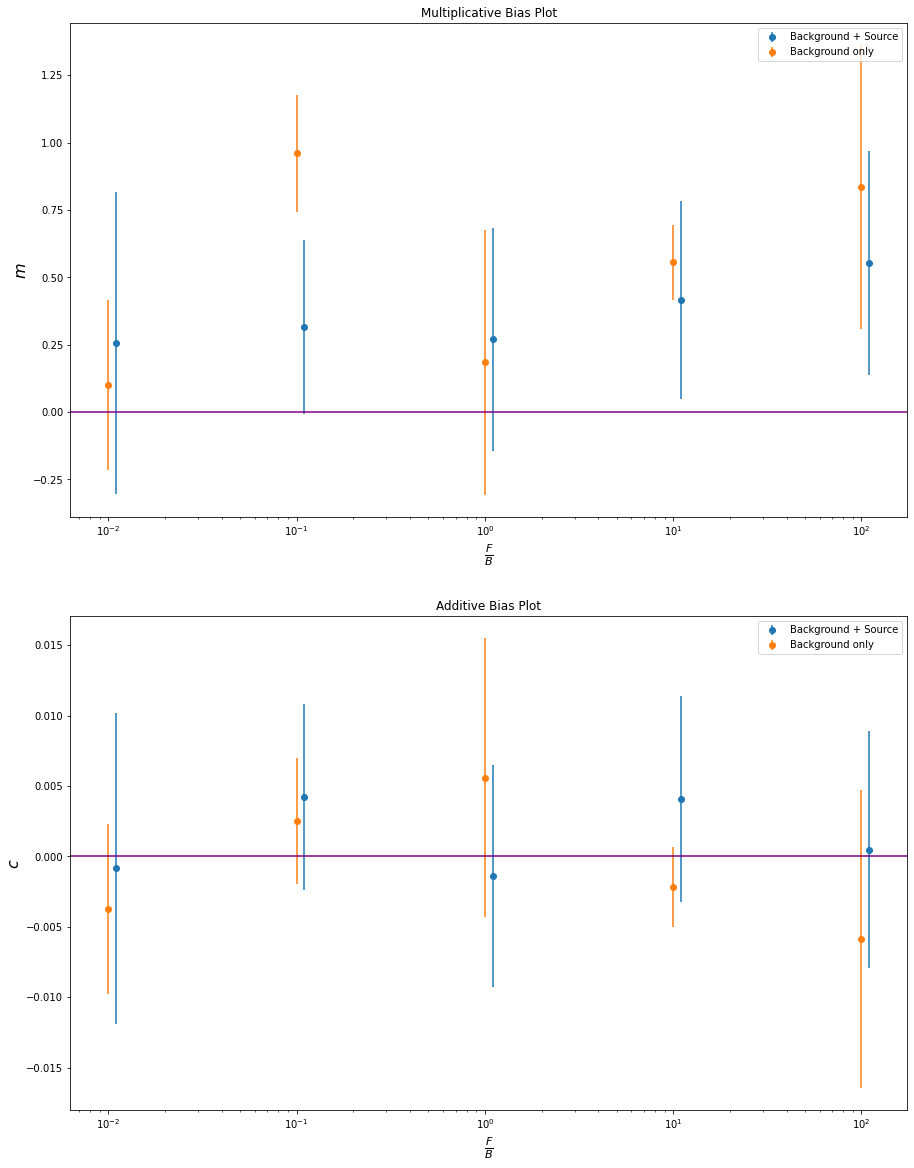

In [21]:
fig, (p1, p2) = plt.subplots(2, figsize=(15,20))

print(biasListSB)
print(biasListB)

plot1 = p1.errorbar(np.array(FBratioArr)*1.1, mListSB, mErrSB, fmt='o', label='Background + Source')
p1.errorbar(FBratioArr, mListB, mErrB, fmt='o', label='Background only')
p1.set_title("Multiplicative Bias Plot")
p1.axhline(0, color="purple")
p1.set_xlabel(r'$\frac{F}{B}$', fontsize=16)
p1.set_ylabel(r'$m$', fontsize=16)
p1.set_xscale("log")
p1.legend()

plot2 = p2.errorbar(np.array(FBratioArr)*1.1, cListSB, cErrSB, fmt='o', label='Background + Source')
p2.errorbar(FBratioArr, cListB, cErrB, fmt = 'o', label ='Background only')
p2.axhline(0, color="purple")
p2.set_xlabel(r'$\frac{F}{B}$', fontsize=16)
p2.set_ylabel(r'$c$', fontsize=16)
p2.set_xscale("log")
p2.set_title("Additive Bias Plot")
p2.legend()

plt.show()